# PIV analysis in droplets

The key is to apply a mask. Sometimes the mask is dynamic.

In [107]:
from openpiv import tools, pyprocess, validation, filters, scaling
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import io
import os
from scipy.signal import medfilt2d
import pandas as pd

In [6]:
frame_a = io.imread(os.path.join('test_images', '03125.tif'))
frame_b = io.imread(os.path.join('test_images', '03126.tif'))

In [23]:
winsize = 20 # pixels, interrogation window size in frame A
searchsize = 30  # pixels, search area size in frame B
overlap = 10 # pixels, 50% overlap
dt = 0.02 # sec, time interval between the two frames

u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32),
    frame_b.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

In [24]:
x, y = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=searchsize,
    overlap=overlap,
    window_size=winsize
)

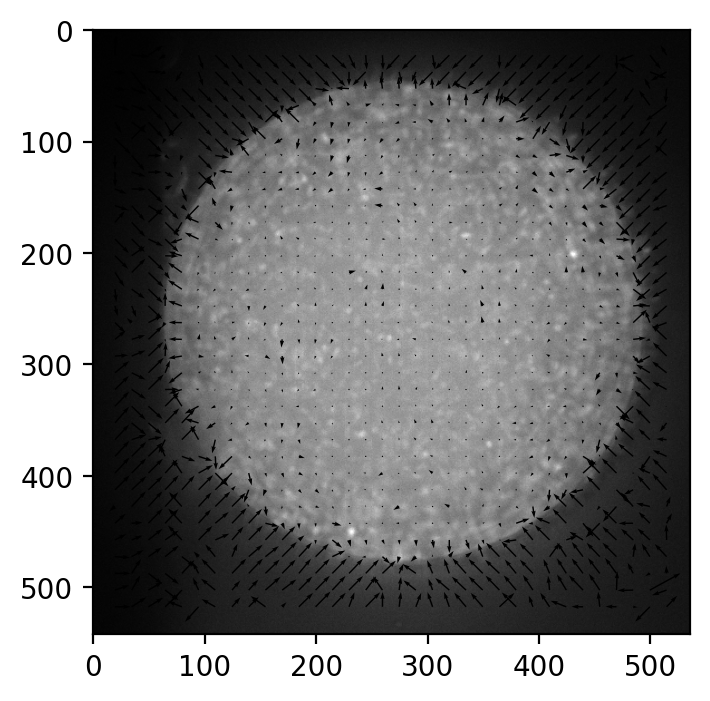

In [11]:
plt.figure(dpi=200)
plt.imshow(frame_a, cmap='gray')
plt.quiver(x, y, u0, v0)

In [25]:
# apply mask
# frame ImageJ, we obtain the position and size of the droplet: x0, y0 and d
# x0, y0 are the upper left corner coords
# d is the diameter of the droplet
x0 = 59
y0 = 43
d = 438

In [26]:
# translate the representation into center-radius representation
r = d / 2
xc = x0 + r
yc = y0 + r

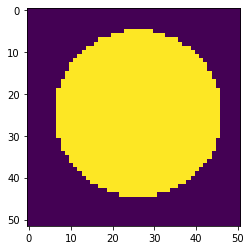

In [35]:
m = (x-xc) ** 2 + (y-yc) ** 2 < (r-winsize) ** 2
plt.imshow(m)

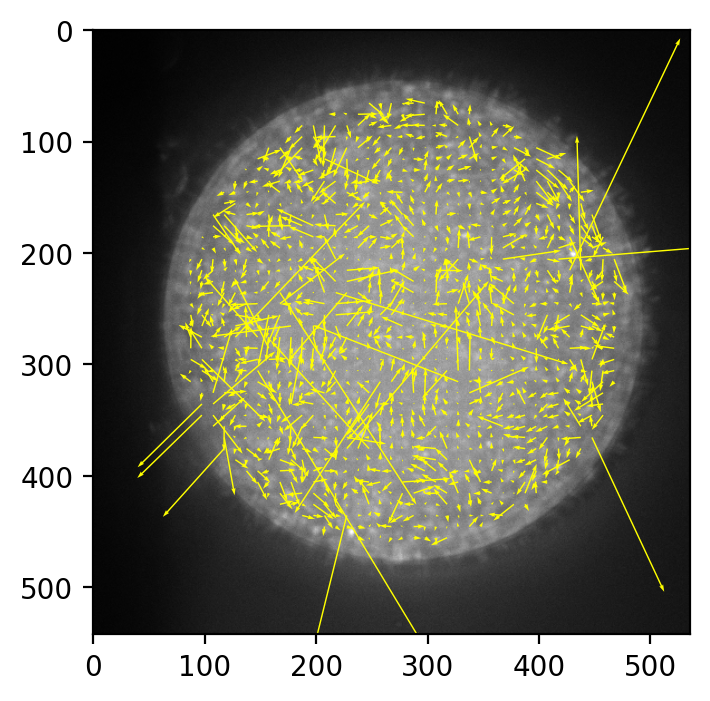

In [40]:
plt.figure(dpi=200)
plt.imshow(frame_a, cmap='gray')
um = u0 * m
vm = v0 * m
xm = x * m
ym = y * m
plt.quiver(xm, ym, um, vm, color='yellow')

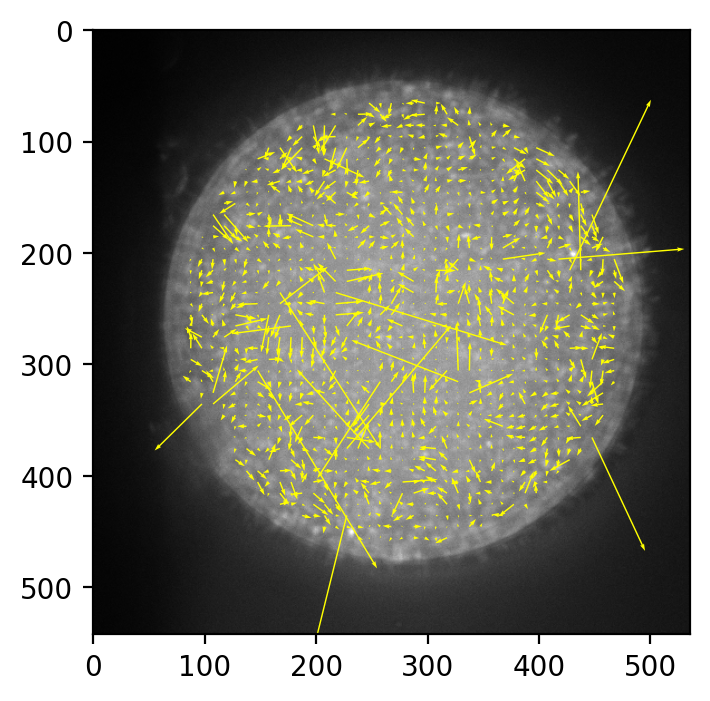

In [41]:
u1, v1, mask = validation.sig2noise_val(
    um, vm,
    sig2noise,
    threshold = 1.05,
)

plt.figure(dpi=200)
plt.imshow(frame_a, cmap='gray')
plt.quiver(xm, ym, u1, v1, color='yellow')

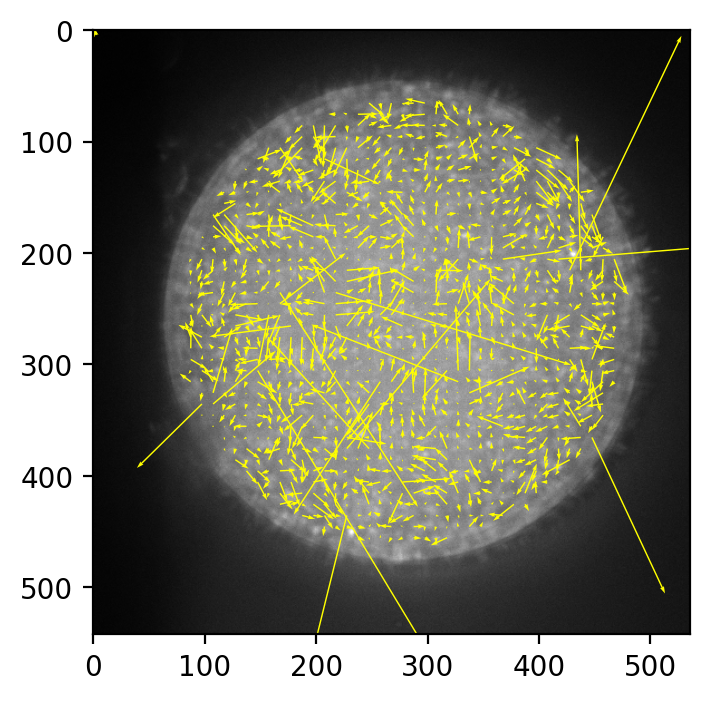

In [42]:
u2, v2 = filters.replace_outliers(
    u1, v1,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)

plt.figure(dpi=200)
plt.imshow(frame_a, cmap='gray')
plt.quiver(xm, ym, u2, v2, color='yellow')

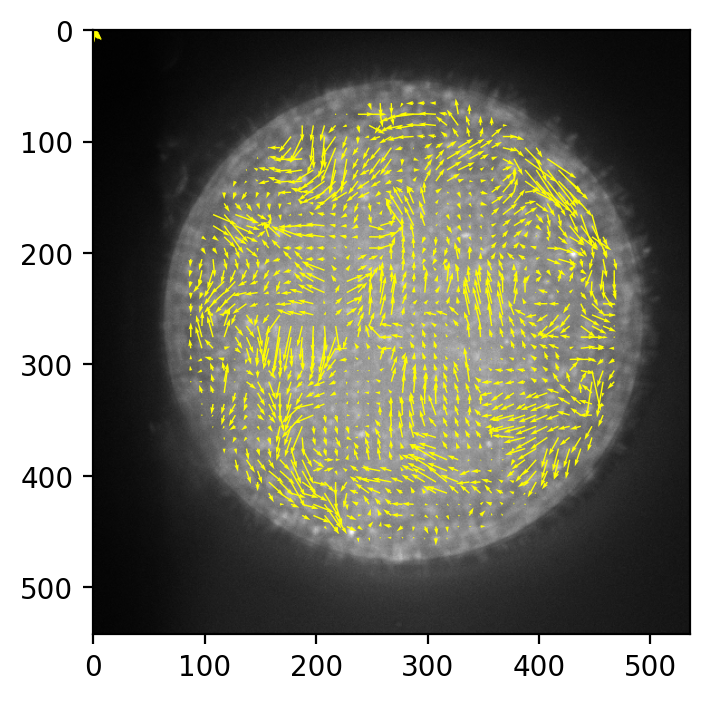

In [43]:
u3 = medfilt2d(u2, 3)
v3 = medfilt2d(v2, 3)

plt.figure(dpi=200)
plt.imshow(frame_a, cmap='gray')
plt.quiver(xm, ym, u3, v3, color='yellow')

Text(0, 0.5, 'v (px/frame)')

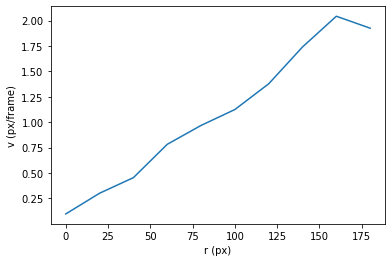

In [53]:
# azimuthal velocity profile (0:r-w:dr)
dr = winsize
r_list = []
v_list = []
for i in np.arange(0, r-winsize, dr):
    r2 = (xm - xc) ** 2 + (ym - yc) ** 2
    mask = (r2 > i**2) & (r2 < (i + dr) ** 2)
    mean_v = (((u3 * mask) ** 2 + (v3 * mask) ** 2) ** 0.5).mean()
    r_list.append(i)
    v_list.append(mean_v)
plt.plot(r_list, v_list)
plt.xlabel('r (px)')
plt.ylabel('v (px/frame)')

In [ ]:
# pix/frame -> 0.16um/0.02s

## Bright field image test

In [54]:
frame_a = io.imread(os.path.join('test_images', 'bf_images', '06972.tif'))
frame_b = io.imread(os.path.join('test_images', 'bf_images', '06973.tif'))

In [57]:
# apply ROI
x0, y0 = 132, 8
w, h = 691, 805
xc, yc = 416, 417
r = 790 / 2

In [95]:
def apply_ROI(img, x0, y0, w, h):
    """Apply ROI to the input image
    Args:
    img -- input image, an numpy.array
    x0, y0, w, h -- upper left corner coords, width and height of ROI
    Returns:
    cropped -- image within the ROI, cropped image
    Test:
    x0, y0 = 132, 8
    w, h = 691, 805
    test_img = io.imread(os.path.join('test_images', 'bf_images', '06972.tif'))
    test_img_cropped = apply_ROI(test_img, x0, y0, w, h)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(test_img)
    ax[1].imshow(test_img_cropped)"""
    return img[y0:y0+h, x0:x0+w]

In [62]:
frame_a_crop = frame_a[y0:y0+h, x0:x0+w]
frame_b_crop = frame_b[y0:y0+h, x0:x0+w]

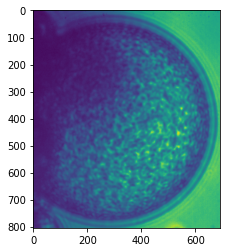

In [61]:
plt.imshow(frame_a_crop)

In [96]:
winsize = 40 # pixels, interrogation window size in frame A
searchsize = 40  # pixels, search area size in frame B
overlap = 20 # pixels, 50% overlap
dt = 0.02 # sec, time interval between the two frames

u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a_crop.astype(np.int32),
    frame_b_crop.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

In [97]:
x, y = pyprocess.get_coordinates(
    image_size=frame_a_crop.shape,
    search_area_size=searchsize,
    overlap=overlap,
    window_size=winsize
)

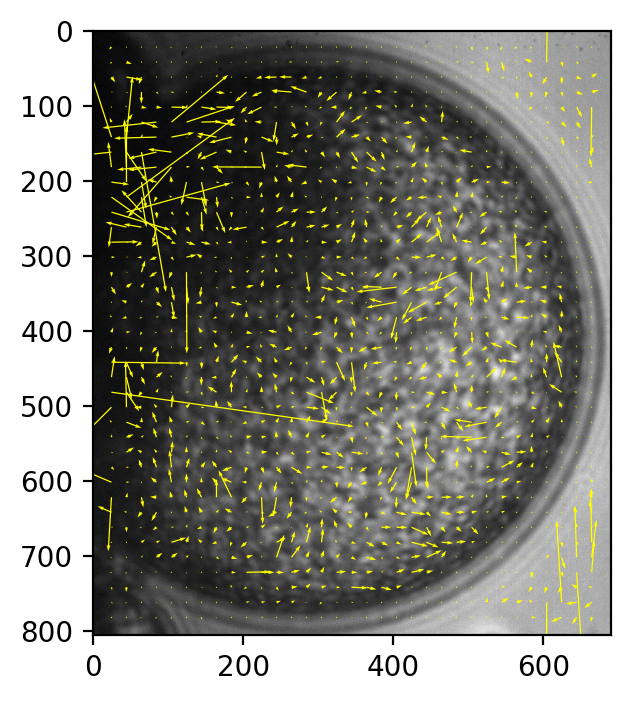

In [98]:
plt.figure(dpi=200)
plt.imshow(frame_a_crop, cmap='gray')
plt.quiver(x, y, u0, v0, color='yellow')

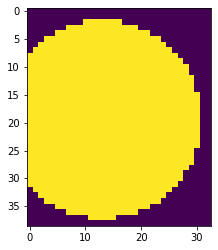

In [99]:
# generate mask
xcr, ycr = xc-x0, yc-y0
mask = (x-xcr) ** 2 + (y-ycr) ** 2 < (r-winsize) ** 2
plt.imshow(mask)

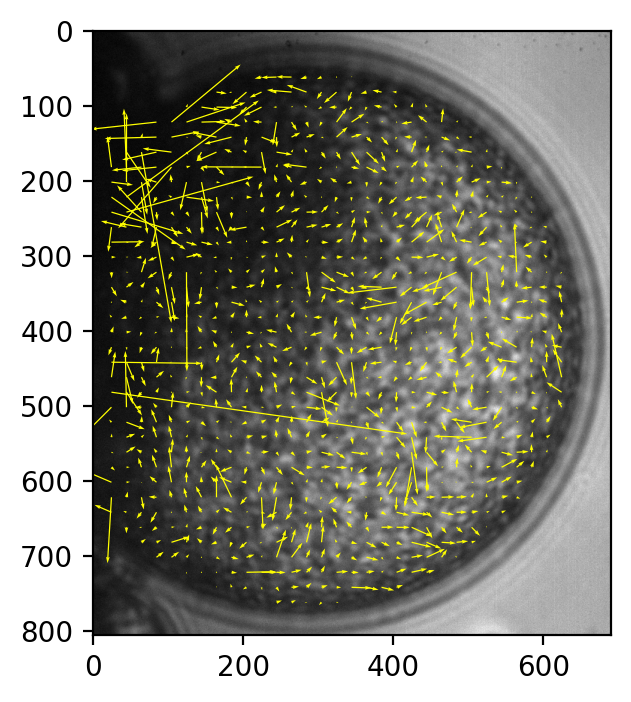

In [100]:
plt.figure(dpi=200)
plt.imshow(frame_a_crop, cmap='gray')
um = u0 * mask
vm = v0 * mask
xm = x * mask
ym = y * mask
plt.quiver(xm, ym, um, vm, color='yellow')

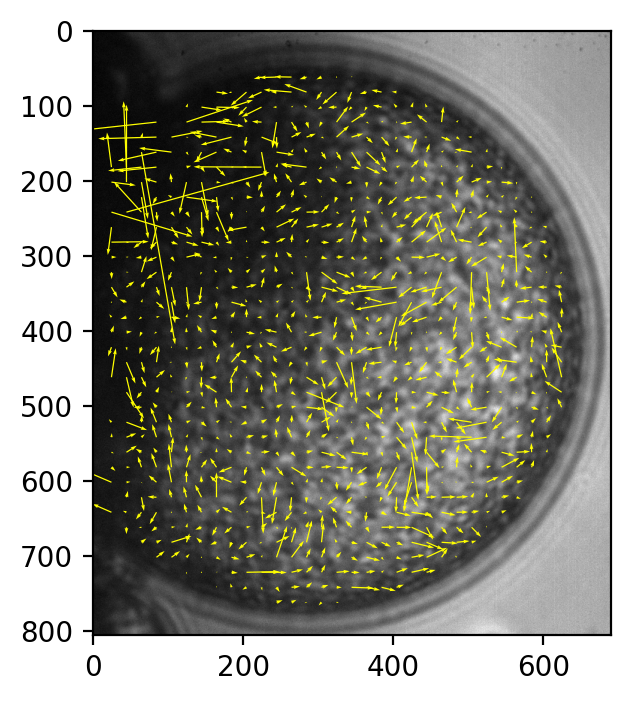

In [101]:
u1, v1, mask = validation.sig2noise_val(
    um, vm,
    sig2noise,
    threshold = 1.05,
)

plt.figure(dpi=200)
plt.imshow(frame_a_crop, cmap='gray')
plt.quiver(xm, ym, u1, v1, color='yellow')

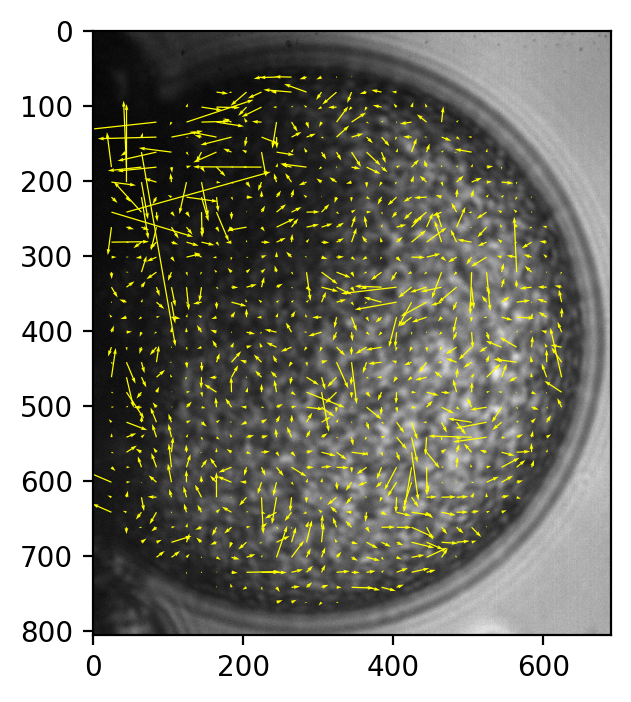

In [102]:
u2, v2 = filters.replace_outliers(
    u1, v1,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)

plt.figure(dpi=200)
plt.imshow(frame_a_crop, cmap='gray')
plt.quiver(xm, ym, u2, v2, color='yellow')

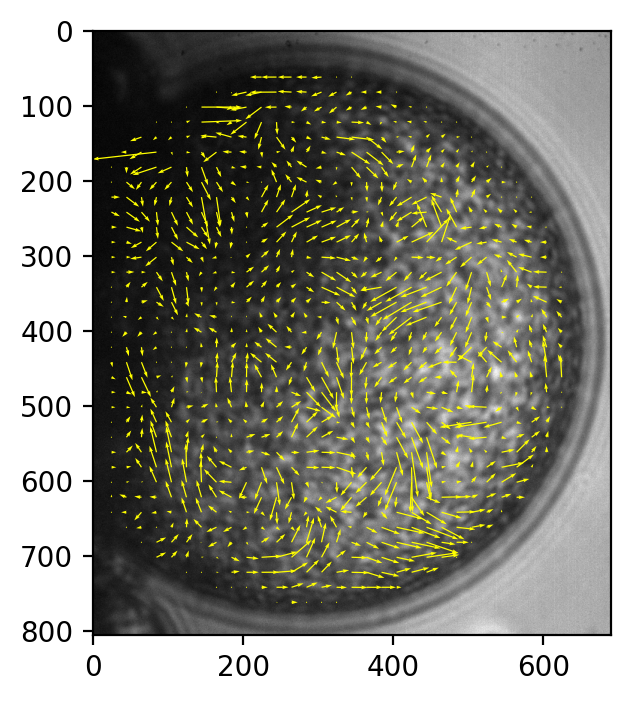

In [103]:
u3 = medfilt2d(u2, 3)
v3 = medfilt2d(v2, 3)

plt.figure(dpi=200)
plt.imshow(frame_a_crop, cmap='gray')
plt.quiver(xm, ym, u3, v3, color='yellow')

Text(0, 0.5, 'v (px/frame)')

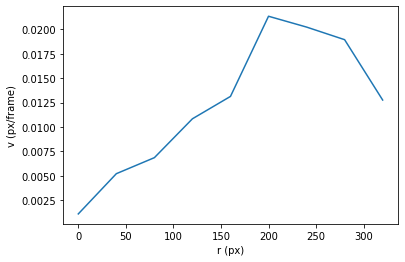

In [104]:
# azimuthal velocity profile (0:r-w:dr)
dr = winsize
r_list = []
v_list = []
for i in np.arange(0, r-winsize, dr):
    r2 = (xm - xcr) ** 2 + (ym - ycr) ** 2
    mask = (r2 > i**2) & (r2 < (i + dr) ** 2)
    mean_v = (((u3 * mask) ** 2 + (v3 * mask) ** 2) ** 0.5).mean()
    r_list.append(i)
    v_list.append(mean_v)
plt.plot(r_list, v_list)
plt.xlabel('r (px)')
plt.ylabel('v (px/s)')

In [106]:
u3.min()

-0.8798379788826338

In [145]:
def PIV_droplet(I0, I1, ROI, circle, winsize=40, overlap=20, dt=0.02):
    """Perform PIV analysis on the image sequence in given folder. Specific for images of droplets.
    Args:
    I0, I1 -- adjacent images in a sequence
    ROI -- 4-tuple, (x0, y0, w, h)
    circle -- indicate droplet position (wrt raw image upper left corner) and size
    Returns:
    frame_data -- x, y, u, v DataFrame, here x, y is wrt original image, (u, v) are in px/s"""
    # apply ROI
    I0_crop = apply_ROI(I0, *ROI).astype(np.int32)
    I1_crop = apply_ROI(I1, *ROI).astype(np.int32)
    # PIV
    u0, v0, sig2noise = pyprocess.extended_search_area_piv(
        I0_crop.astype(np.int32),
        I1_crop.astype(np.int32),
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=winsize,
        sig2noise_method='peak2peak',
    )
    # get x, y
    x, y = pyprocess.get_coordinates(
        image_size=I0_crop.shape,
        search_area_size=winsize,
        overlap=overlap,
        window_size=winsize
    )
    x0, y0, w, h = ROI
    x, y = x + x0, y + y0
    # generate circle mask
    xc, yc, r = circle
    xcr, ycr = xc-x0, yc-y0
    mask = (x-xc) ** 2 + (y-yc) ** 2 <= (r-winsize) ** 2
    # apply mask to velocities and coordinates

#     xm = x * mask
#     ym = y * mask
    # signal to noise validation
    u1, v1, mask_s2n = validation.sig2noise_val(
        u0, v0,
        sig2noise,
        threshold = 1.05,
    )
    # replace_outliers
    u2, v2 = filters.replace_outliers(
        u1, v1,
        method='localmean',
        max_iter=3,
        kernel_size=3,
    )
    # median filter smoothing
    u3 = medfilt2d(u2, 3)
    v3 = medfilt2d(v2, 3)
    u3[~mask] = np.nan
    v3[~mask] = np.nan
    # generate DataFrame data
    frame_data = pd.DataFrame(
        data=np.array([x.flatten(), y.flatten(), u3.flatten(), v3.flatten()]).T, 
        columns=['x', 'y', 'u', 'v'])
    return frame_data

In [146]:
# test
I0 = io.imread(os.path.join('test_images', 'bf_images', '06972.tif'))
I1 = io.imread(os.path.join('test_images', 'bf_images', '06973.tif'))
ROI = (132, 8, 691, 805)
circle = 416, 417, 395
df = PIV_droplet(I0, I1, ROI, circle, winsize=40, overlap=20, dt=0.02)

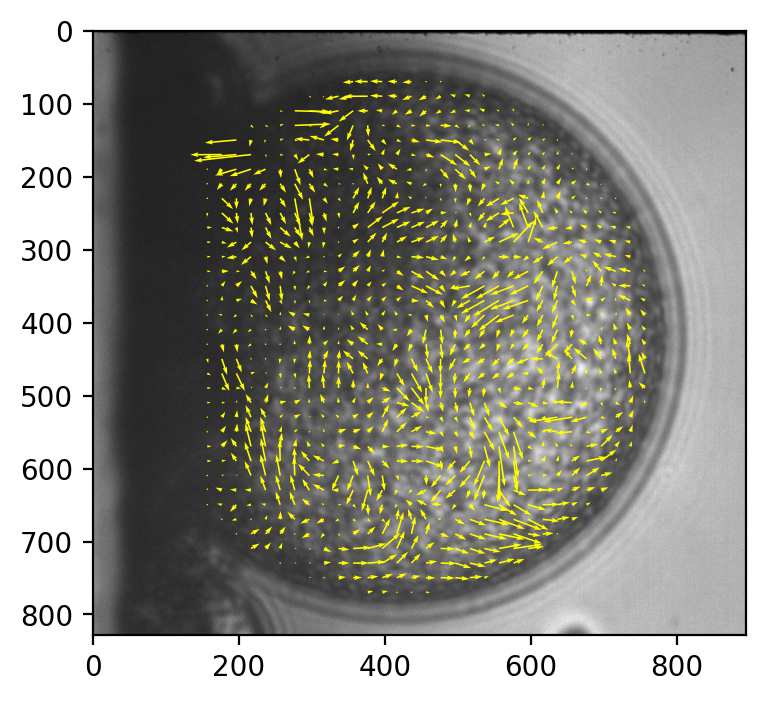

In [148]:
plt.figure(dpi=200)
plt.imshow(I0, cmap='gray')
plt.quiver(df.x, df.y, df.u, df.v, color='yellow')
# plt.axis('equal')

In [158]:
param_dir = os.path.join('test_images', 'params.txt')
with open(param_dir, 'r') as f:
    a = f.read()
    print(a)

1, 2.6, 2, 
4, 500, 400, 54,
300, 100, 200


In [165]:
np.char.strip(np.array(a.split(','))).astype('float')

array([  1. ,   2.6,   2. ,   4. , 500. , 400. ,  54. , 300. , 100. ,
       200. ])

In [177]:
def read_params(params_file):
    """Read piv_drop parameters from params_file."""
    with open(params_file, 'r') as f:
        a = f.read()
    params = np.char.strip(np.array(a.split(','))).astype('float')
    return params[0].astype('int'), params[1].astype('int'), params[2], \
        params[3:7].astype('int'), params[7:]

In [180]:
param_dir = os.path.join('test_images', 'params.txt')
winsize, overlap, dt, ROI, circle = read_params(param_dir)

In [182]:
df = PIV_droplet(I0, I1, ROI, circle, winsize, overlap, dt)

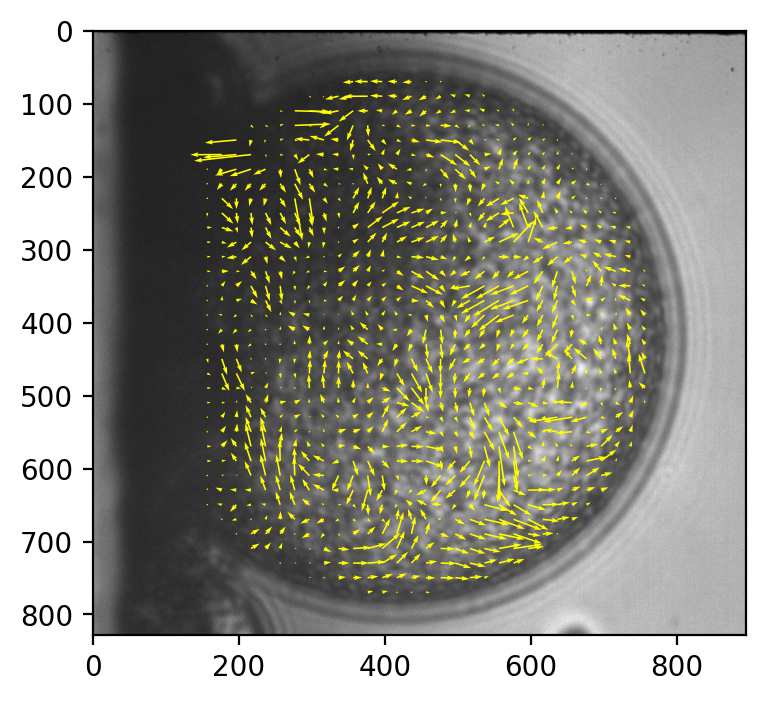

In [183]:
plt.figure(dpi=200)
plt.imshow(I0, cmap='gray')
plt.quiver(df.x, df.y, df.u, df.v, color='yellow')

## Server result test

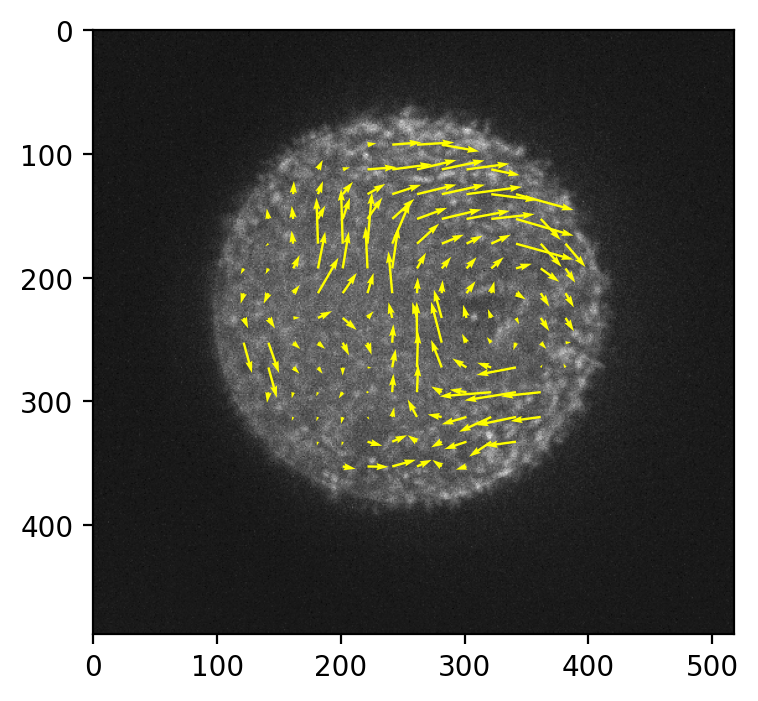

In [186]:
img = io.imread(r"C:/Users/liuzy/Documents/Data/DE/12092021/preview/24.tif")
piv = pd.read_csv(r"C:/Users/liuzy/Documents/Data/DE/12092021/preview/00000-00001.csv")
plt.figure(dpi=200)
plt.imshow(img, cmap='gray')
plt.quiver(piv.x, piv.y, piv.u, piv.v, color='yellow')

In [187]:
# generate mask files, need to improve the work flow for batch processing
folder = r"C:/Users/liuzy/Documents/Data/DE/12092021/preview"
for i in range(0, 23):
    with open(os.path.join(folder, "mask-{:02d}.txt".format(i)), "w") as f:
        f.write("40, 20, 0.02,")